# Capstone Project - Short Answer Grading

## SciEntsBank Data and Modeling

In [2]:
## Coisas Feitas
# Fiz uma serie de modelos binario (classificar se a resposta é correta ou não), testando no dataframe seb e no dataframe sag, com resultados satisfatorios
# foi realizado uma comparacao de vetorizadores e modelos, mudando tambem quem seria o gerador do vetorizador (que foi variado entre reference answer e answer) onde o melhor resultado foi obtido com o vetorizador com answer como gerador
# inicialmente foi percebido que o modelo xgboost, associado com o vetorizador de hash se saiu melhor em termos de f1 score

## Coisas a fazer
# Fazer um modelo regressor ou multiclassificador (para classificar a nota em graus) para o dataframe sag
# Realizar uma comparacao mais profunda entre os modelos e vetorizadores para o dataframe seb e sag
# estudar formas de vetorizacao como embeddings, word2vec, glove, etc
# estudar formas de melhorar o modelo, como por exemplo, aumentar o numero de dados
# classificacao atraves do bert
# classificacao atraves de um modelo de deep learning
# regressao para dar a nota em graus


In [3]:
import pandas as pd
import os
import numpy as np

# should be the name of directory you created to save your features data
data_dir = 'data/sag'

## Analyzing Source Data

In [4]:
raw_data = pd.read_csv(os.path.join(data_dir, "answers.csv"))

In [14]:
raw_data.head()

,id,answer,score,correct
0,1.1,High risk problems are address in the prototyp...,3.5,0.0
1,1.1,To simulate portions of the desired final prod...,5.0,1.0
2,1.1,A prototype program simulates the behaviors of...,4.0,1.0
3,1.1,Defined in the Specification phase a prototype...,5.0,1.0
4,1.1,It is used to let the users have a first idea ...,3.0,0.0


In [5]:
raw_data.corr()

,id,score,correct
id,1.000000,0.071011,0.082731
score,0.071011,1.000000,0.871701
correct,0.082731,0.871701,1.000000


In [6]:
raw_data.describe()

,id,score,correct
count,2442.000000,2442.000000,2442.000000
mean,7.202211,4.190571,0.725225
std,3.688497,1.112038,0.446492
min,1.100000,0.000000,0.000000
25%,3.700000,3.500000,0.000000
50%,7.400000,5.000000,1.000000
75%,10.600000,5.000000,1.000000
max,12.900000,5.000000,1.000000


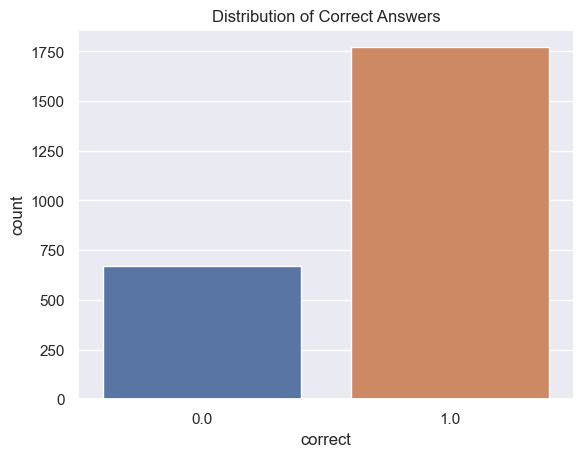

In [13]:
# plot the pie distribution of the target variable with title "Distribution of Correct Answers" and labels
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(x="correct", data=raw_data)
plt.title("Distribution of Correct Answers")
plt.show()


C:\Users\Rodrigues\anaconda3\envs\Pictures\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


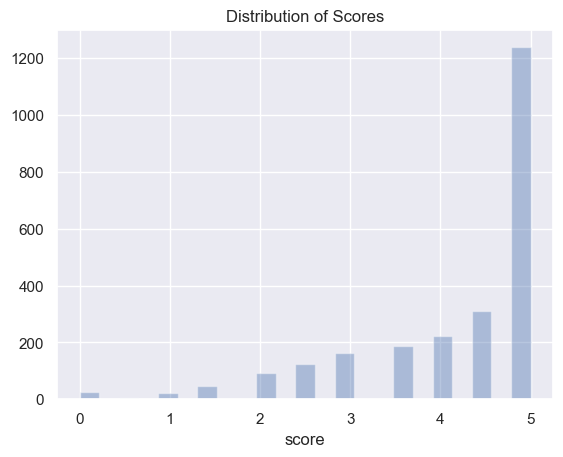

In [15]:
# plot the distribution of scores with title "Distribution of Scores" and labels
sns.distplot(raw_data['score'], kde=False)
plt.title("Distribution of Scores")
plt.show()


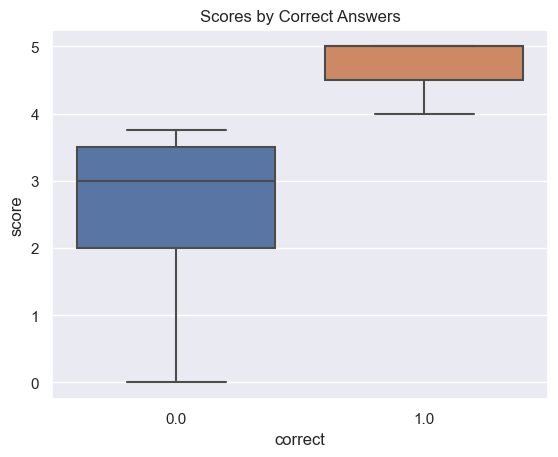

In [16]:
# boxplot of scores by correct answers
sns.boxplot(x="correct", y="score", data=raw_data)
plt.title("Scores by Correct Answers")
plt.show()


In [9]:
raw_data.correct.value_counts()

1.0    1771
0.0     671
Name: correct, dtype: int64

C:\Users\Rodrigues\anaconda3\envs\Pictures\lib\site-packages\ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


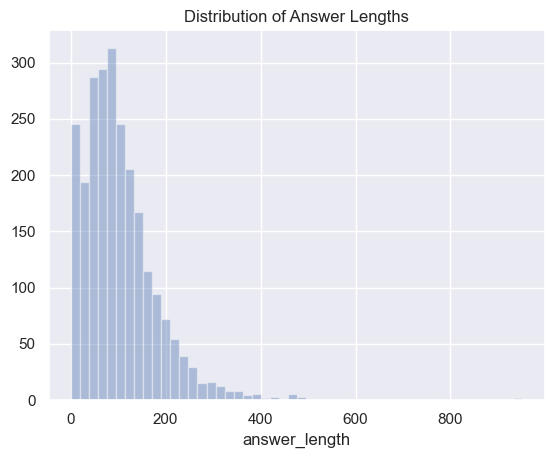

In [20]:
# create column of length of answer text and plot distribution of length with title "Distribution of Answer Lengths"
raw_data['answer_length'] = raw_data['answer'].apply(lambda x: len(x))
sns.distplot(raw_data['answer_length'], kde=False)
plt.title("Distribution of Answer Lengths")
plt.show()


C:\Users\Rodrigues\anaconda3\envs\Pictures\lib\site-packages\ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


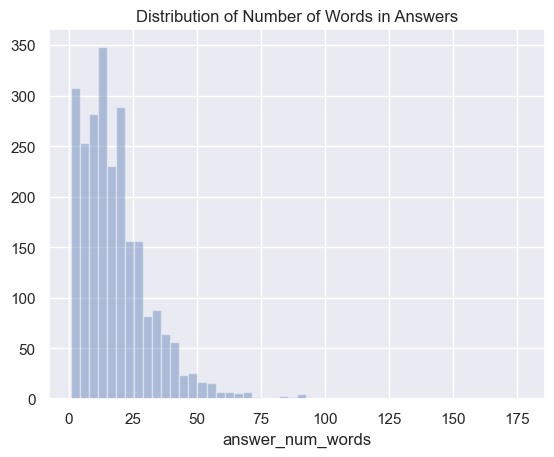

In [22]:
# create column of number of words in answer text and plot distribution of number of words with title "Distribution of Number of Words in Answers"
raw_data['answer_num_words'] = raw_data['answer'].apply(lambda x: len(x.split()))
sns.distplot(raw_data['answer_num_words'], kde=False)
plt.title("Distribution of Number of Words in Answers")
plt.show()


In [ ]:
# plot correlation matrix of all features with title "Correlation Matrix" removing id column
corr = raw_data.drop('id', axis=1).corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.title("Correlation Matrix")
plt.show()


In [73]:
#split raw_data into train and test
train_data = raw_data.sample(frac=0.8,random_state=200)
test_data = raw_data.drop(train_data.index)


In [74]:
# define a fuction that preprocesses the data
def preprocess(data):
    # remove punctuation
    data['answer'] = data['answer'].str.replace('[^\w\s]','')
    # convert to lower case
    data['answer'] = data['answer'].str.lower()
    # remove numbers
    data['answer'] = data['answer'].str.replace('\d+', '')
    # remove extra spaces
    data['answer'] = data['answer'].str.replace(' +', ' ')
    # remove leading and trailing spaces
    data['answer'] = data['answer'].str.strip()
    return data

# define vectorizer method
def vectorize(data, method):
    if method == 'tfidf':
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer()
    elif method == 'count':
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer = CountVectorizer()
    elif method == 'hash':
        from sklearn.feature_extraction.text import HashingVectorizer
        vectorizer = HashingVectorizer()
    elif method == 'word2vec':
        from gensim.models import Word2Vec
        vectorizer = Word2Vec(data['answer'].str.split(), window=5, min_count=1, workers=4)
    elif method == 'doc2vec':
        from gensim.models.doc2vec import Doc2Vec, TaggedDocument
        documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['answer'].str.split())]
        vectorizer = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
    elif method == 'fasttext':
        from gensim.models import FastText
        vectorizer = FastText(data['answer'].str.split(), window=5, min_count=1, workers=4)
    else:
        print('Invalid vectorizer method')
    return vectorizer

In [75]:
# preprocess train and test data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

C:\Users\Rodrigues\anaconda3\envs\Pictures\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Rodrigues\anaconda3\envs\Pictures\lib\site-packages\ipykernel_launcher.py:8: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Rodrigues\anaconda3\envs\Pictures\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

The default value of regex will change from True to False in a future version.



In [77]:
VECTORIZER_BY_REFERENCE = False

# fit vectorizer with train data and transform train and test data for each vectorizer method
vectorizer_methods = ['tfidf', 'count', 'hash']
vectorizers = {}

methods_df = pd.DataFrame()

for method in vectorizer_methods:
    print('Vectorizing with ' + method)
    print('Reference vectorizer: ' + str(VECTORIZER_BY_REFERENCE))
    print('Fitting vectorizer...')
    vectorizer = vectorize(train_data, method)
    vectorizers[method] = vectorizer
    vectorizer.fit(train_data['reference_answer'] if VECTORIZER_BY_REFERENCE else train_data['answer']) if method not in ['word2vec', 'doc2vec', 'fasttext', 'universal_sentence_encoder', 'bert', 'roberta', 'albert', 'xlnet', 'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'elmo', 'albert', 'albert-large', 'albert-xlarge', 'albert-xxlarge'] else vectorizer
    train_vectors = vectorizer.transform(train_data['answer']) if method not in ['word2vec', 'doc2vec', 'fasttext', 'universal_sentence_encoder', 'bert', 'roberta', 'albert', 'xlnet', 'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'elmo', 'albert', 'albert-large', 'albert-xlarge', 'albert-xxlarge'] else vectorizer(train_data['answer'])
    test_vectors = vectorizer.transform(test_data['answer']) if method not in ['word2vec', 'doc2vec', 'fasttext', 'universal_sentence_encoder', 'bert', 'roberta', 'albert', 'xlnet', 'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'elmo', 'albert', 'albert-large', 'albert-xlarge', 'albert-xxlarge'] else vectorizer(test_data['answer'])
    methods_df[method] = [train_vectors, test_vectors]



Vectorizing with tfidf
Reference vectorizer: False
Fitting vectorizer...
Vectorizing with count
Reference vectorizer: False
Fitting vectorizer...
Vectorizing with hash
Reference vectorizer: False
Fitting vectorizer...


In [78]:
# define a function that trains a model and returns the accuracy

def train_model(train_vectors, train_labels, model):
    if model == 'logistic':
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(train_vectors, train_labels)
    elif model == 'svm':
        from sklearn import svm
        clf = svm.SVC(gamma='scale').fit(train_vectors, train_labels)
    elif model == 'random_forest':
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(train_vectors, train_labels)
    elif model == 'knn':
        from sklearn.neighbors import KNeighborsClassifier
        clf = KNeighborsClassifier(n_neighbors=3).fit(train_vectors, train_labels)
    elif model == 'decision_tree':
        from sklearn.tree import DecisionTreeClassifier
        clf = DecisionTreeClassifier(random_state=0).fit(train_vectors, train_labels)
    elif model == 'xgboost':
        from xgboost import XGBClassifier
        clf = XGBClassifier().fit(train_vectors, train_labels)
    else:
        print('Invalid model')
    return clf


In [79]:
# train and test each model for each vectorizer method, results are stored in a dataframe for comparison purposes
# results are the accuracy, f1 score, precision, recall and roc_auc_score, for each model and vectorizer method

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

models = ['logistic', 'svm', 'random_forest', 'knn', 'decision_tree', 'xgboost']
results_df = pd.DataFrame(columns=['accuracy', 'f1_score', 'precision', 'recall', 'roc_auc_score'])

for method in vectorizer_methods:
    print('Training with ' + method)
    train_vectors = methods_df[method][0]
    test_vectors = methods_df[method][1]
    for model in models:
        print('Training ' + model)
        clf = train_model(train_vectors, train_data['correct'], model)
        predict_y = clf.predict(test_vectors)
        accuracy = clf.score(test_vectors, test_data['correct'])
        f1 = f1_score(test_data['correct'], predict_y)
        precision = precision_score(test_data['correct'], predict_y)
        recall = recall_score(test_data['correct'], predict_y)
        roc_auc = roc_auc_score(test_data['correct'], predict_y)
        results_df.loc[model + '_' + method] = [accuracy, f1, precision, recall, roc_auc]



Training with tfidf
Training logistic
Training svm
Training random_forest
Training knn
Training decision_tree
Training xgboost
[16:51:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Rodrigues\anaconda3\envs\Pictures\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Training with count
Training logistic
Training svm


C:\Users\Rodrigues\anaconda3\envs\Pictures\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training random_forest
Training knn
Training decision_tree
Training xgboost
[16:51:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training with hash
Training logistic


C:\Users\Rodrigues\anaconda3\envs\Pictures\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Training svm
Training random_forest
Training knn
Training decision_tree
Training xgboost
[16:52:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Rodrigues\anaconda3\envs\Pictures\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



In [80]:
# plot all results (accuracy, f1, roc_auc) with a horizontal bar chart in plotly

import plotly.graph_objects as go

results_df = results_df.sort_values(by=['accuracy'], ascending=False)
title = f'Accuracy, F1 Score and ROC AUC Score for each model and vectorizer method (with train and test data vectorized by {"train reference answer" if VECTORIZER_BY_REFERENCE else "train answer"})'
fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=results_df['accuracy'], y=results_df.index, orientation='h'),
    go.Bar(name='F1 Score', x=results_df['f1_score'], y=results_df.index, orientation='h'),
    go.Bar(name='ROC AUC', x=results_df['roc_auc_score'], y=results_df.index, orientation='h')
])
fig.update_layout(barmode='group', title=title)
fig.show()


In [112]:
# plot all results (accuracy, f1, roc_auc) with a horizontal bar chart in plotly

import plotly.graph_objects as go

results_df = results_df.sort_values(by=['accuracy'], ascending=False)
title = f'Accuracy, F1 Score and ROC AUC Score for each model and vectorizer method (with train and test data vectorized by {"train reference answer" if VECTORIZER_BY_REFERENCE else "train answer"})'
fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=results_df['accuracy'], y=results_df.index, orientation='h'),
    go.Bar(name='F1 Score', x=results_df['f1_score'], y=results_df.index, orientation='h'),
    go.Bar(name='ROC AUC', x=results_df['roc_auc_score'], y=results_df.index, orientation='h')
])
fig.update_layout(barmode='group', title=title)
fig.show()
